<a href="https://colab.research.google.com/github/nasimkashefi/fashion/blob/main/fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install kaggle


In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small


Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT
 97% 548M/565M [00:09<00:00, 99.2MB/s]
100% 565M/565M [00:09<00:00, 60.9MB/s]


In [ ]:
!unzip fashion-product-images-small.zip


Streaming output truncated to the last 5000 lines.
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradataset/images/58150.jpg  
  inflating: myntradataset/imag

In [ ]:
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import tensorflow as tf

SEED = 1


def set_seed(seed=SEED):
    tf.keras.utils.set_random_seed(seed)


set_seed()
import cv2
import matplotlib.patches as patches
import cv2
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import layers
from keras.applications.resnet import preprocess_input
from keras.applications import ResNet50
from keras.layers import Input, Flatten, Dense, Concatenate, Activation, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [ ]:
data = pd.read_csv('/content/styles.csv',on_bad_lines='skip')

data = data.dropna()
data = pd.DataFrame(data)

image_path = '/content/images'

In [ ]:
def show_k_random(k, name):
    choices = np.random.choice(data.index, k, replace=False)
    choices = data.loc[choices, ['id', name]]
    fig, axs = plt.subplots(1, k, figsize=(15, 10))
    for this_name, id, ax in zip(choices[name], choices['id'], axs.ravel()):
        img_path = f"{image_path}/{id}.jpg"
        img = plt.imread(img_path)
        ax.imshow(img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'{this_name}')
    plt.tight_layout()
    plt.show()

In [24]:
data

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume


gender


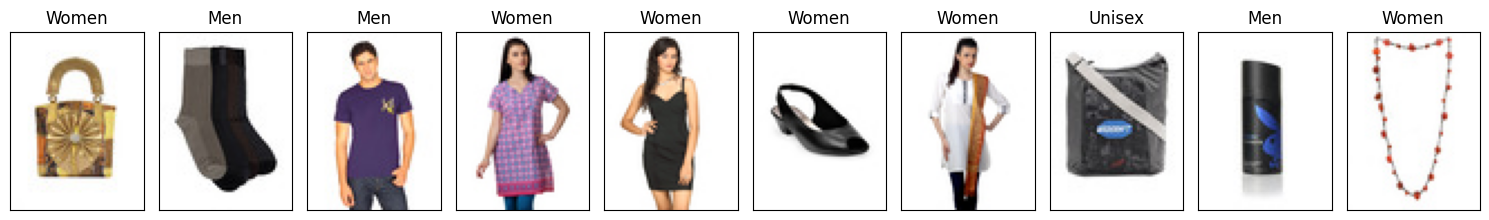

masterCategory


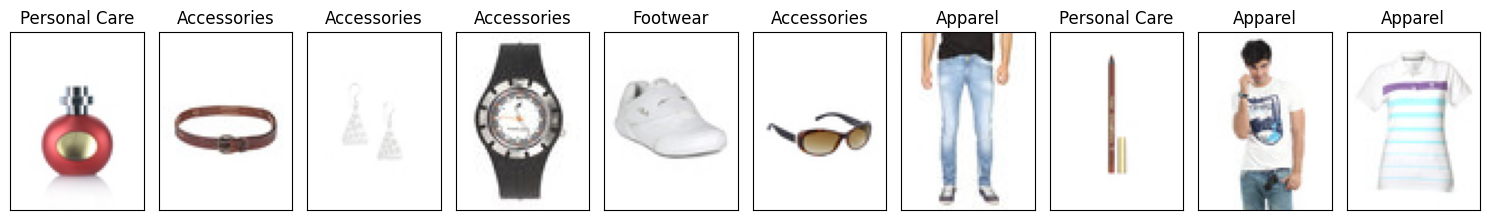

subCategory


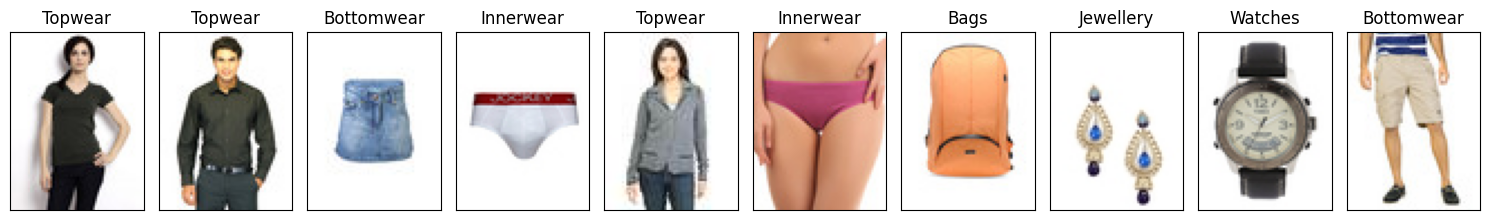

articleType


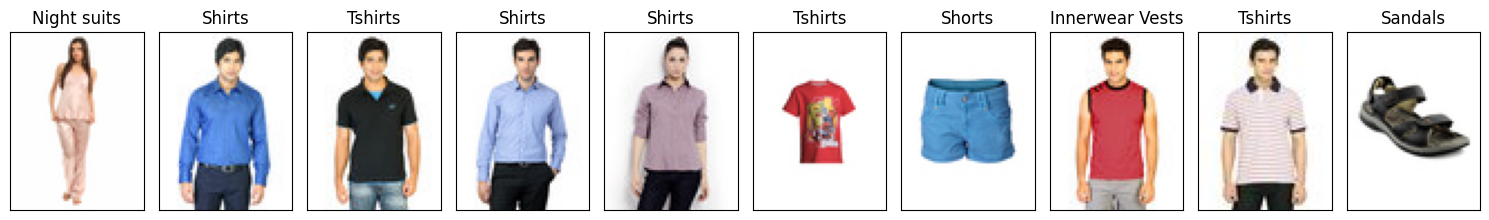

baseColour


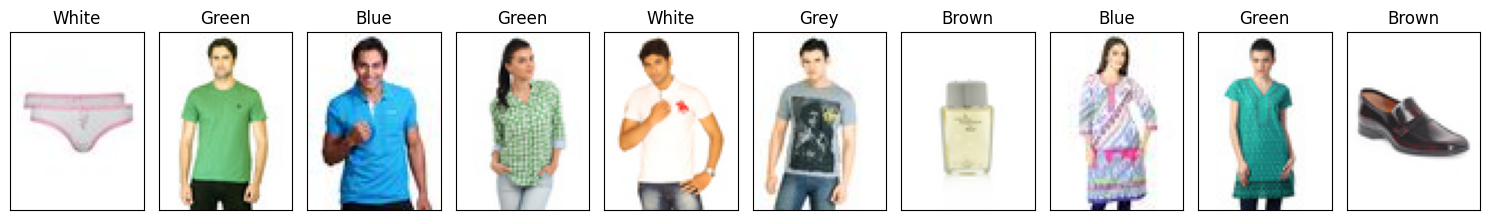

season


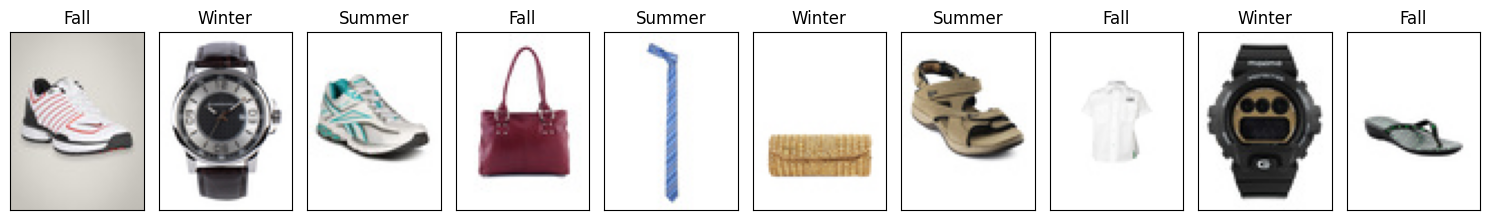

year


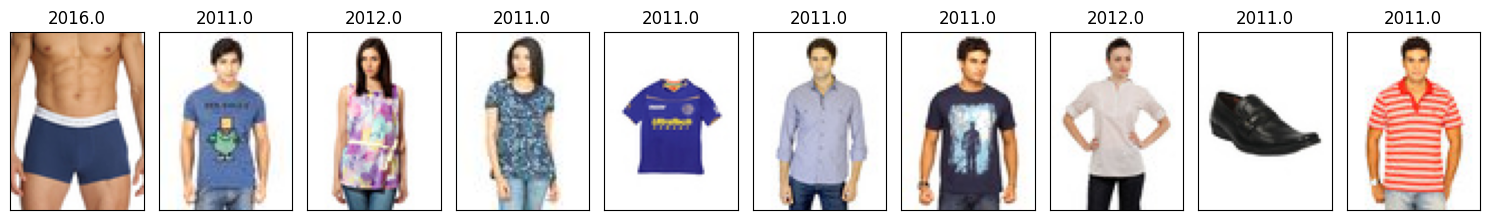

usage


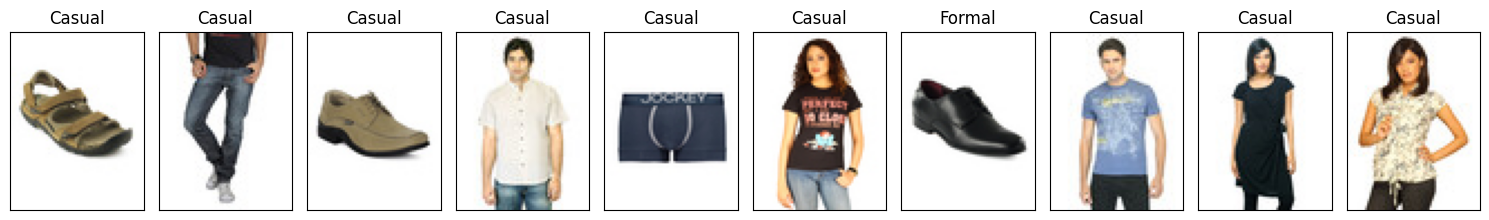

In [25]:
labels = data.columns[1:-1]
for col in labels:
    print(col)
    show_k_random(10, col)

In [ ]:
print(labels)

Index(['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour',
       'season', 'year', 'usage'],
      dtype='object')


In [ ]:
print(data.index)

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       44414, 44415, 44416, 44417, 44418, 44419, 44420, 44421, 44422, 44423],
      dtype='int64', length=44077)


In [ ]:
print(data.iloc[-1].index)

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')


In [ ]:
new_data = data.copy()
new_data = new_data.drop(columns=['productDisplayName'])
for col in new_data.columns:
  if col != 'id' and col != 'baseColour':
    unique_values = data[col].unique()
    category_mapping = {category: idx + 1 for idx, category in enumerate(unique_values)}
    new_data[col] = data[col].map(category_mapping)
new_data['path']=None
for i in new_data.index:
  new_data.loc[i,'path'] = f"{image_path}/{data.loc[i,'id']}.jpg"
new_data

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,path
0,15970,1,1,1,1,Navy Blue,1,1,1,/content/images/15970.jpg
1,39386,1,1,2,2,Blue,2,2,1,/content/images/39386.jpg
2,59263,2,2,3,3,Silver,3,3,1,/content/images/59263.jpg
3,21379,1,1,2,4,Black,1,1,1,/content/images/21379.jpg
4,53759,1,1,1,5,Grey,2,2,1,/content/images/53759.jpg
...,...,...,...,...,...,...,...,...,...,...
44419,17036,1,3,5,7,White,2,8,1,/content/images/17036.jpg
44420,6461,1,3,7,9,Red,2,1,1,/content/images/6461.jpg
44421,18842,1,1,1,5,Blue,1,1,1,/content/images/18842.jpg
44422,46694,2,4,12,27,Blue,4,4,1,/content/images/46694.jpg


In [ ]:
new_data.isna().sum()

,0
id,0
gender,0
masterCategory,0
subCategory,0
articleType,0
baseColour,0
season,0
year,0
usage,0
path,0


In [ ]:
color_map = {
    # Neutral Tones
    'Beige': 'Brown',
    'Black': 'Black',
    'Charcoal': 'Gray',
    'Cream': 'White',
    'Grey': 'Gray',
    'Grey Melange': 'Gray',
    'Khaki': 'Brown',
    'Mushroom Brown': 'Brown',
    'Nude': 'Brown',
    'Off White': 'White',
    'Silver': 'Gray',
    'Steel': 'Gray',
    'Tan': 'Brown',
    'Taupe': 'Brown',
    'White': 'White',

    # Red and Pink Tones
    'Burgundy': 'Red',
    'Maroon': 'Red',
    'Mauve': 'Pink',
    'Pink': 'Pink',
    'Rose': 'Pink',
    'Red': 'Red',

    # Orange and Brown Tones
    'Bronze': 'Brown',
    'Brown': 'Brown',
    'Coffee Brown': 'Brown',
    'Copper': 'Brown',
    'Rust': 'Brown',

    # Yellow Tones
    'Gold': 'Yellow',
    'Mustard': 'Yellow',
    'Peach': 'Yellow',
    'Yellow': 'Yellow',

    # Green Tones
    'Fluorescent Green': 'Green',
    'Green': 'Green',
    'Lime Green': 'Green',
    'Olive': 'Green',
    'Sea Green': 'Green',

    # Blue Tones
    'Blue': 'Blue',
    'Navy Blue': 'Blue',
    'Teal': 'Blue',
    'Turquoise Blue': 'Blue',

    # Purple and Violet Tones
    'Lavender': 'Purple',
    'Magenta': 'Purple',
    'Purple': 'Purple',

    # Orange Tones
    'Orange': 'Brown',

    # Unique/Other Colors
    'Metallic': 'Gray',
    'Multi': 'Multi',
    'Skin': 'Yellow',
}
new_data['baseColour'] = data['baseColour'].map(color_map)

In [ ]:
new_data

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,path
0,15970,1,1,1,1,Blue,1,1,1,/content/images/15970.jpg
1,39386,1,1,2,2,Blue,2,2,1,/content/images/39386.jpg
2,59263,2,2,3,3,Gray,3,3,1,/content/images/59263.jpg
3,21379,1,1,2,4,Black,1,1,1,/content/images/21379.jpg
4,53759,1,1,1,5,Gray,2,2,1,/content/images/53759.jpg
...,...,...,...,...,...,...,...,...,...,...
44419,17036,1,3,5,7,White,2,8,1,/content/images/17036.jpg
44420,6461,1,3,7,9,Red,2,1,1,/content/images/6461.jpg
44421,18842,1,1,1,5,Blue,1,1,1,/content/images/18842.jpg
44422,46694,2,4,12,27,Blue,4,4,1,/content/images/46694.jpg


<Axes: >

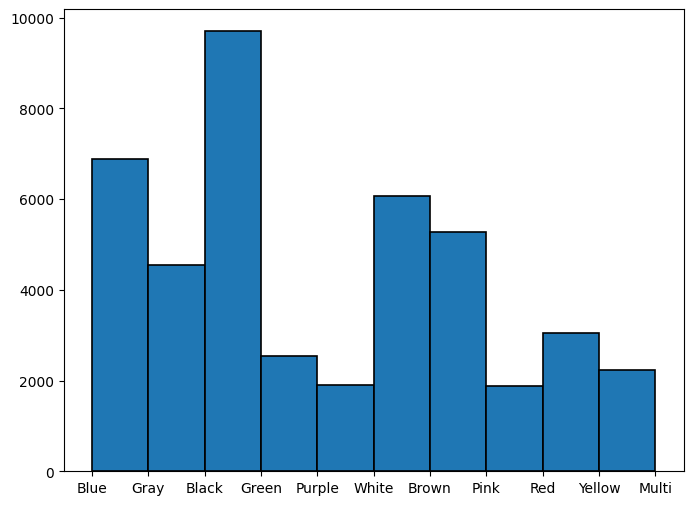

In [ ]:
new_data['baseColour'].hist(figsize=(8, 6), grid=False, edgecolor='black', linewidth=1.2)

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'gender'}>,
        <Axes: title={'center': 'masterCategory'}>],
       [<Axes: title={'center': 'subCategory'}>,
        <Axes: title={'center': 'articleType'}>,
        <Axes: title={'center': 'season'}>],
       [<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'usage'}>, <Axes: >]], dtype=object)

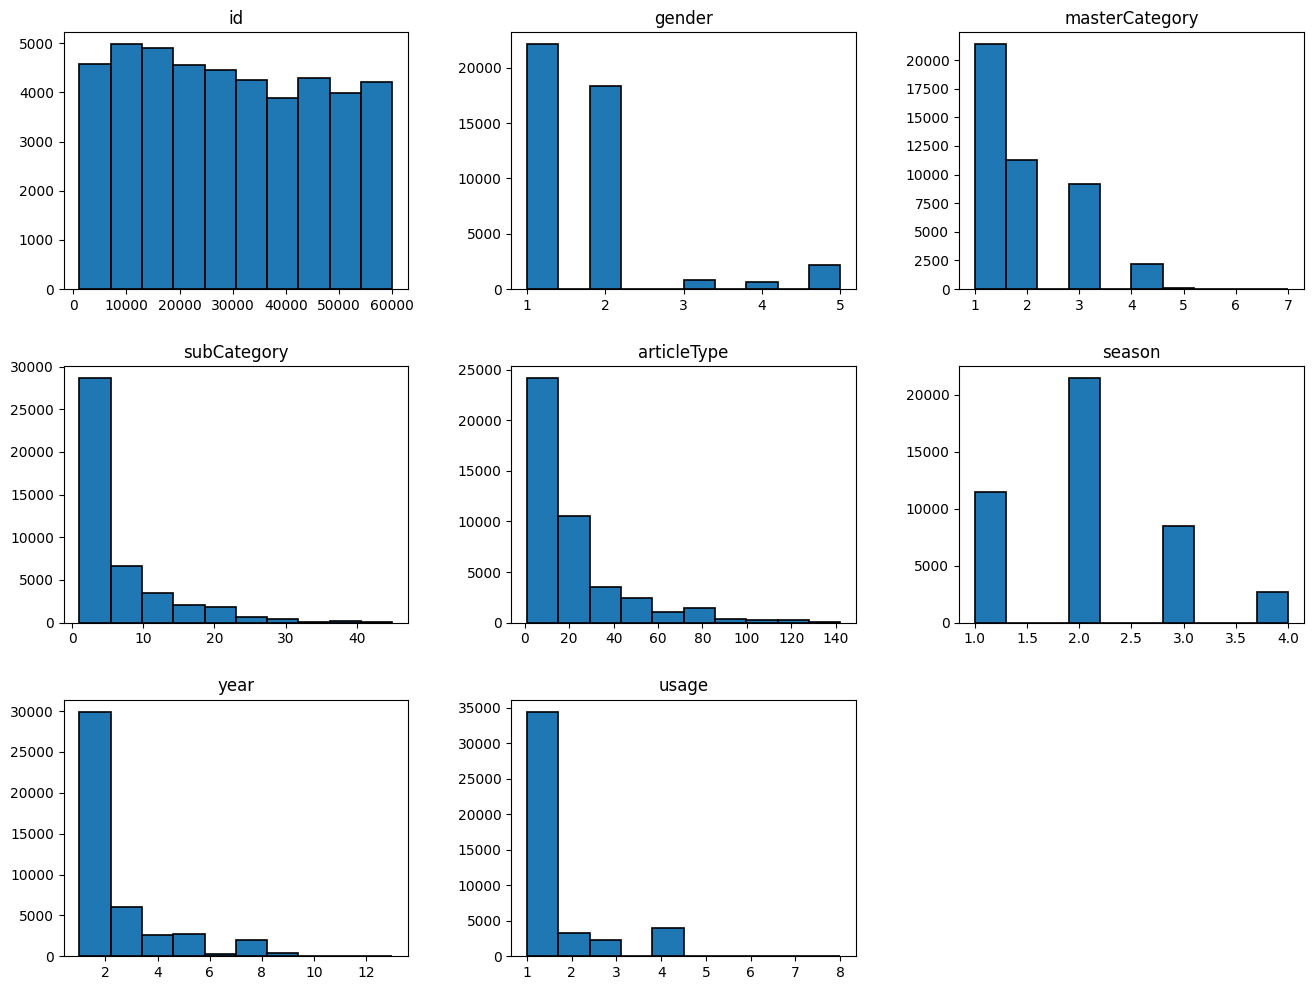

In [ ]:
new_data.hist(figsize=(16, 12), grid=False, edgecolor='black', linewidth=1.2)

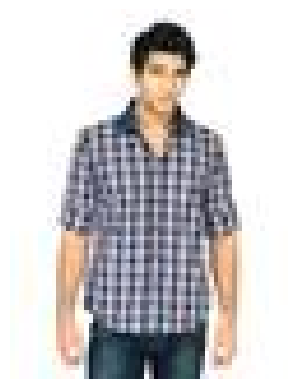

In [ ]:
img = mpimg.imread(new_data.loc[0,'path'])
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

In [ ]:
widths = []
heights = []
for path in new_data['path']:
  if os.path.exists(path):
    img = mpimg.imread(path)
    shape = img.shape
    # print(shape[0])
    widths.append(shape[0])
    heights.append(shape[1])

In [ ]:
unique_widths = pd.Series(widths).unique()
unique_heights = pd.Series(heights).unique()

print("Unique values using pandas:", unique_widths)
print("Unique values using pandas:", unique_heights)

Unique values using pandas: [80 60 75 76 77 79]
Unique values using pandas: [60 53 54]
